In [1]:
#Linear Regression Models
#Chapter 3
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Temp Functions to be deleted
#plots heat map of multi_gauss
def plot_multi_gauss(x,y,mu,covar):
    nbins = 50
    xx,yy = np.mgrid[x.min():x.max():nbins*1j,y.min():y.max():nbins*1j]
    xxyy = np.vstack([xx.flatten(), yy.flatten()]).T
    zz = multi_gauss(xxyy,mu,covar)
    plt.pcolormesh(xx,yy,zz.reshape(xx.shape))
    plt.show()
    
#multi gauss
def multi_gauss(x,mu,cov):
    D = len(mu)
    a = 1.0/(np.power(2*np.pi,D/2.0))

    b = 1.0/(np.power(np.linalg.det(cov),.5))

    c = np.exp((-.5)*(maha_dist(x,mu,cov)))
    return a*b*c

#mahalanobis dist
def maha_dist(x,mu,cov):
    diff = x-mu
    ret = np.matmul(diff,np.linalg.inv(cov))
    ret = np.matmul(ret,diff.T)
    return ret.diagonal()

In [3]:
def sin(x):
    return np.sin(x)

def cos(x):
    return np.cos(x)

def pw(x,n):
    return np.power(x,n)

def gauss_sample(m,s):
    return np.random.normal(m,s)

def Y(x,m,b):
    return (m*x)+b

def nlin_fun(x):
    y = (10*sin(x))+Y(x,0.2,-.5)-(3*cos(2*x))
    return y

def sigmoid(x):
    return 1.0/(1+np.exp(-x))

def sigmoid_basis(x,mu,s):
    N = len(mu)
    x = np.outer(np.transpose(x),np.ones(N))
    diff = np.subtract(x,mu)
    return sigmoid((1.0/s)*diff)

def gauss_basis(x,mu,s):
    N = len(mu)
    x = np.outer(np.transpose(x),np.ones(N))
    diff = np.subtract(x,mu)
    n = np.power(diff,2)
    d = 2*np.power(s,2)
    f = (1.0/d)*n
    return np.exp(-f)

def poly_basis(x,deg):
    if (deg == 0):
        return np.zeros(len(x)).reshape(len(x),1)
    x = np.outer(np.transpose(x),np.ones(deg))
    return np.power(x,np.arange(1,deg+1,1))

#returns wegihts based on zero mean gaussian
def get_weights(numb):
    return np.random.normal(0,.5,numb)

def get_centers(x,n_bfun):
    if len(x) == 1:
        c = np.random.normal(x[0],.3,n_bfun)
        return c
    if n_bfun == 0:
        return []
    if n_bfun == 1:
        return [np.average(x)]
    mi = min(x)
    ma = max(x)
    delt = (ma-mi)/n_bfun
    cen = []
    while mi<ma and len(cen)<n_bfun:
        cen.append(mi)
        mi = mi+delt
    
    return cen

def moore_pen_inv(phi):
    m = np.matmul(np.transpose(phi),phi)
    m = np.matmul(np.linalg.inv(m),np.transpose(phi))
    return m

#The approxiamte function y(x,w) given input x
#weights and basis functions
def approx_y(w,x,c,n_bf,s,p):
    b,c = pick_basis(x,n_bf-1,s,p)
    g = np.ones(len(x))
    g = np.insert(b,0,g,1)
    return np.matmul(w,np.transpose(g))


#Returns maximum likelihood weights and basis functions
#for linear regression
#pts is the input points
#n_bf is the number of basis functions
#s is the spatial component of the basis
#v is the type of basis function 1->gauss 2->sigmoid
def max_likelihood_lin_reg(pts,n_bf,s,p):
    x = pts[:,0]
    y = pts[:,1]
    
    g = np.ones(len(x))
    bf,c = pick_basis(x,n_bf-1,s,p)
    g = np.insert(bf,0,g,1)
    w = np.matmul(moore_pen_inv(g),y)
    return w,g,c

#Returns maximum likelihood weights and basis functions
#for linear regression with regularization term
#pts is the input points
#n_bf is the number of basis functions
#s is the spatial component of the basis
#p is the type of basis function 1->gauss 2->sigmoid
#rg_fac is the regularization factor 
def max_likelihood_lin_reg_rg(pts,n_bf,s,p,rg_fac):
    x = pts[:,0]
    y = pts[:,1]
    
    #c = get_centers(x,n_bf-1)
    g = np.ones(len(x))
    bf,c = pick_basis(x,n_bf-1,s,p)
    g = np.insert(bf,0,g,1)
    shp = np.shape(g)
    rg_I = rg_fac*np.eye(shp[1],shp[1],dtype=float)
    
    #calculating weight vector
    a = rg_I+np.matmul(np.transpose(g),g)
    b = np.matmul(np.linalg.inv(a),np.transpose(g))
    w = np.matmul(b,y) 
    return w,g,c

#Returns basis func
def pick_basis(data,n_bf,s,p):
    if ((p==1) or (p==2)):
        c = get_centers(data,n_bf)
        
    if (p == 1):
        return gauss_basis(data,c,s),c
    elif (p==2):
        return sigmoid_basis(data,c,s),c
    elif (p==3):
        return poly_basis(data,n_bf),0
    
#Parameter Distribution Posterior Estimation
#p(w|t,m_0,s_0)
def weight_dist_post(data,prior_mean,prior_covariance,noise,n_bf,s,p):
    
    x = data[:,0]
    y = data[:,1]
    phi,c = pick_basis(x,n_bf-1,s,p)
    g = np.ones(len(x))
    phi = np.insert(phi,0,g,1)
    
    a = noise*np.matmul(np.transpose(phi),phi)
    post_cov_inv = np.linalg.inv(prior_covariance)+a
    
    a = noise*np.matmul(np.transpose(phi),y)
    a = np.matmul(np.linalg.inv(prior_covariance),prior_mean)+a
    post_mean = np.matmul(np.linalg.inv(post_cov_inv),a)
    
    return post_mean,np.linalg.inv(post_cov_inv),c

#Linear regression on linear function defined by paramteres
#m and b
def post_weights_linear_example(m,b):
    x = np.arange(0,3,.002)
    print("Len x",len(x))
    print("Min x",min(x))
    print("Max x",max(x))
    
    np.random.shuffle(x)
    y = gauss_sample(Y(x,m,b),.3)
    pts = np.stack((x,y),axis=1)
    
    n = 0
    s = .5
    n_bf = 2
    p = 3
    m = np.array([1,1])
    cov = np.array([[1,3.0/5],[3.0/5,2]])
    cen = []
    len_x = len(x)
    print(len_x)

    wx = np.arange(m[0]-2*(.1),(m[0]+2*(.1)),.01)
    wy = np.arange(m[1]-2*(.1),(m[1]+2*(.1)),.01)
    plot_multi_gauss(wx,wy,m,cov)

    while n<(len_x):
        m,cov,c = weight_dist_post(pts[n:n+5],m,cov,25,n_bf,s,p)
        n = n+5

    
    ww,gg,cc = max_likelihood_lin_reg(pts,8,s,1)
    yy = approx_y(ww,x,cc,8,s,1)
    
    
    print("Weights post:", m)
    print("Covariance", cov)
    wx = np.arange(m[0]-2*(.1),(m[0]+2*(.1)),.01)
    wy = np.arange(m[1]-2*(.1),(m[1]+2*(.1)),.01)
    plot_multi_gauss(wx,wy,m,cov)

    #def approx_y(w,x,c,s,p):
    yyy = Y(x,m[1],m[0])
    plt.plot(x,y,'.')
    plt.plot(x,yy,'.')
    plt.plot(x,yyy,'.')
    plt.legend(["True","Estimate_ML","Estiamte_Post"])
    plt.show()
    
#Posterior weights distribution non linear function
#Example
def post_weights_nonlin_example():
    x = np.arange(0,2*np.pi,.02)
    print("Len x",len(x))
    print("min x",min(x))
    print("max x",max(x))

    np.random.shuffle(x)
    y = gauss_sample((10*sin(x))+Y(x,0.2,-.5)-(3*cos(2*x)),.3)
    pts = np.stack((x,y),axis=1)


    n = 0
    s = .5
    n_bf = 10
    p = 1
    m = np.array([1,1,1,1,1,1,1,1,1,1])
    cov = np.random.rand(10,10)
    cen = []
    len_x = len(x)

    while n<(len_x):
        m,cov,c = weight_dist_post(pts[n:n+20],m,cov,25,n_bf,s,p)
        cen.append(c)
        n = n+20

    
    ww,gg,cc = max_likelihood_lin_reg(pts,8,s,1)
    yy = approx_y(ww,x,cc,8,s,1)

    print("Weight Estimates",  m)

    yyy = approx_y(m,x,cen,10,s,1)
    plt.plot(x,y,'.')
    plt.plot(x,yy,'.')
    plt.plot(x,yyy,'.')
    plt.legend(["True","Estimate_ML","Estiamte_Post"])
    plt.show()

#Equivalent Kernel Approximation
def equivalent_kernel(x,xn,n_bf,cov,noise,s,p):
    phi_x,c = pick_basis(x,n_bf-1,s,p)
    phi_xn,c = pick_basis(xn,n_bf-1,s,p)
    g_x = np.ones(len(x))
    g_xn = np.ones(len(xn))
    phi_x = np.insert(phi_x,0,g_x,1)
    phi_xn = np.insert(phi_xn,0,g_xn,1)
    
    
    a = noise*phi_x
    a = np.matmul(a,cov)
    a = np.matmul(a,np.transpose(phi_xn))
    return a

#Evidence Approximation for hyper parameters
#p(alpha,beta|t)



#Performs a kernel estimation example on a non linear function
def kernel_example():
    x = np.arange(-2*np.pi,2*np.pi,.01)
    np.random.shuffle(x)
    y = gauss_sample(nlin_fun(x),1)
    #y = gauss_sample(Y(x,5,.3),1)
    pts = np.stack((x,y),axis=1)
    
    n = 0
    s = 1
    n_bf = 10
    m = np.zeros(10)
    cov = np.random.rand(10,10)
    len_x = len(x)
    p=1
    
    while n<(len_x):
        m,cov,c = weight_dist_post(pts[n:n+20],m,cov,25,n_bf,s,p)
        n = n+20
    
    xx = np.arange(-2*np.pi,2*np.pi,.1)
    K = equivalent_kernel(xx,x,n_bf,cov,25,s,p)
    yy = np.matmul(K,y)
    print(np.shape(y))
    yyy = approx_y(m,x,0,10,s,p)
    plt.plot(x,y,'.')
    plt.plot(xx,nlin_fun(xx),'x')
    plt.plot(xx,yy,'x')
    plt.plot(x,yyy,'.')
    plt.legend(["Train data","True Point","Kernel-Estimate","Weight Estimate"])
    plt.show()
    return m,cov,K

[[75.9248383539499, 19.30189496280254], [0.0002324826757801808, 22.057734494826523], [0.0006961571176458938, 22.060018327274307], [0.0008954894303909866, 23.757567839344123], [0.0021803513198130633, 23.77904798466408], [0.017857397322946413, 23.789232143423938], [0.09597032748496327, 23.797611586176515], [0.05499172591964488, 23.779538752974585], [0.03695519644439792, 23.6823506781593], [0.021872256272883597, 23.32548896170411]]
10247.593375188993
8968.296757325175
8967.348901188683
8326.54388057538
8318.766472546573
8314.134742512593
8306.739884008304
8294.223169441693
8253.781771263637
8117.138846973976
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


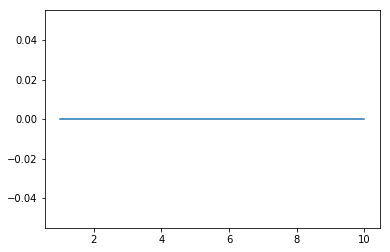

In [6]:
def approx_alpha_beta(x,y,n_bf,s,p,alpha,beta):
    phi,c = pick_basis(x,n_bf-1,s,p)
    g = np.ones(len(x))
    phi = np.insert(phi,0,g,1)
    #Guess alpha
    #find Mn and gamma
    #Then estimate alpha
    #repeat until convergence
    
    n_a = alpha
    n_b = beta
    
    diff_a = 5
    diff_b = 5
    
    r = 0
    while(diff_a>.001 or diff_b>.001):
        a = beta*np.matmul(np.transpose(phi),phi)
        A = alpha*np.eye(np.shape(a)[0])+a
        mn = beta*np.matmul(np.linalg.inv(A),np.matmul(np.transpose(phi),y))
        e_vals,v = np.linalg.eig(a)
        gamma = np.sum(1.0/(e_vals+alpha))
        
        #a
        if (diff_a>.001):
            n_a = gamma/(np.matmul(np.transpose(mn),mn))
            diff_a = np.absolute(n_a-alpha)
            alpha=n_a
        
        #b
        if (diff_b>.001):
            diff = y-np.matmul(mn,np.transpose(phi))
            #diff = np.power(diff,2)
            #diff = np.sum(diff)
            diff = np.linalg.norm(diff)
            inv_b = (1.0/(len(x)-gamma))*diff
            n_b = 1.0/inv_b
            diff_b = np.absolute(n_b-beta)
            beta=n_b
        r=r+1
        #print(diff_a,diff_b)
    return alpha,beta


#Returns the posterior weight distribution
#Given new data x and y
def weight_dist_zero_mean_prior(pts,prior_m,prior_cov,alpha,beta,n_bf,s,p):
    x=  pts[:,0]
    y = pts[:,1]
    
    phi,c = pick_basis(x,n_bf-1,s,p)
    g = np.ones(len(x))
    phi = np.insert(phi,0,g,1)
    
    a = beta*np.matmul(np.transpose(phi),phi)
    post_cov_inv = alpha*np.eye(np.shape(a)[0])+a
    post_m = beta*np.matmul(np.linalg.inv(post_cov_inv),np.matmul(np.transpose(phi),y))
    return post_m,np.linalg.inv(post_cov_inv)


def evidence_approximation(pts,alpha,beta,n_bf,s,p):
    x = pts[:,0]
    #y = pts[:,1]
    N = 20
    M = n_bf
    
    phi,c = pick_basis(x,n_bf-1,s,p)
    g = np.ones(len(x))
    phi = np.insert(phi,0,g,1)
    
    a = beta*np.matmul(np.transpose(phi),phi)
    A = alpha*np.eye(np.shape(a)[0])+a
    mn = beta*np.matmul(np.linalg.inv(A),np.matmul(np.transpose(phi),y))

    Eud = y-np.matmul(phi,mn)
    Eud = np.linalg.norm(Eud)
    Emn = ((beta/2.0)*np.power(Eud,2))+((alpha/2.0)*np.matmul(np.transpose(mn),mn))
    AA = np.power(2*np.pi,M/2.0)*np.power(np.linalg.det(A),-.5)
    it = np.exp(-1*Emn)*AA
    E = np.power(beta/(2*np.pi),N/2.0)*np.power(alpha/(2*np.pi),M/2.0)*it
    return E

    
    
x = np.arange(0,2*np.pi,.01)
np.random.shuffle(x)
y = gauss_sample(sin(x),1)
pts = np.stack((x,y),axis=1)
#def evidence_approx(x,y,n_bf,s,p,alpha,beta):
a = 3
b = 7
p = 3
s = .5
n_bf = np.arange(1,11,1)
m =[[np.zeros(1),np.zeros(2),np.zeros(3),
               np.zeros(4),np.zeros(5),np.zeros(6),
               np.zeros(7),np.zeros(8),np.zeros(9),
               np.zeros(10)]]
#cov = np.random.rand(10,10)


#a,b = evidence_approx(x,y,n_bf,s,p,a,b)
ab = []
for i in range(0,10):
    a = .3
    b = .3
    a,b = approx_alpha_beta(x,y,n_bf[i],s,p,a,b)
    ab.append([a,b])

print(ab)
#evidence_approximation(pts,m,alpha,beta,n_bf,s,p)
e = []
for i in range(0,10):
    ei = evidence_approximation(pts,ab[i][0],ab[i][1],n_bf[i],s,p)
    e.append(ei)

    
print(e)
plt.plot(n_bf,e)
plt.show()